In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier

e:\Bootcamp\DS_Grupo3\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
current_dir = os.getcwd()

parent_dir = os.path.abspath(os.path.join(current_dir, "../.."))
folder_path = 'data'
file_name = 'stroke_woe_smote.csv'

file_path = os.path.join(parent_dir, folder_path, file_name)

df = pd.read_csv(file_path)
df.head()

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,bmi_category,age_category,glucose_level_category,stroke
0,1,0,1,1,0.059265,1,0.559182,0.176297,1.069885,0.921024,1
1,1,0,1,1,0.059265,0,-0.249627,0.176297,1.069885,-0.301429,1
2,0,0,0,1,0.059265,1,0.062398,0.176297,-0.367003,0.921024,1
3,0,1,0,1,0.528860,0,-0.249627,-0.543404,1.069885,0.921024,1
4,1,0,0,1,0.059265,1,0.559182,0.286053,1.069885,0.921024,1


In [3]:
y = df['stroke']
X = df.drop(['stroke'], axis = 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 1337)

eval_set = [(X_train, y_train), (X_test, y_test)]

In [4]:
def objective(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 30),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'leaf_size': trial.suggest_int('leaf_size', 10, 50),
        'p': trial.suggest_int('p', 1, 2)
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)
    accuracies = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]


        model = KNeighborsClassifier(**params)
        model.fit(X_train, y_train)
    
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    
    return sum(accuracies) / len(accuracies)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

final_model = KNeighborsClassifier(**best_params)
final_model.fit(X, y)

[I 2024-10-10 23:52:43,803] A new study created in memory with name: no-name-5002ebdd-d608-4c7d-a323-efcff3b17e4c
[I 2024-10-10 23:52:44,265] Trial 0 finished with value: 0.6226500010319796 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 19, 'p': 2}. Best is trial 0 with value: 0.6226500010319796.
[I 2024-10-10 23:52:45,162] Trial 1 finished with value: 0.6375439218908545 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 17, 'p': 1}. Best is trial 1 with value: 0.6375439218908545.
[I 2024-10-10 23:52:46,090] Trial 2 finished with value: 0.5963453416717289 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 22, 'p': 2}. Best is trial 1 with value: 0.6375439218908545.
[I 2024-10-10 23:52:46,951] Trial 3 finished with value: 0.6883580422732336 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 25, 'p': 2}. Best is tria

KNeighborsClassifier(algorithm='brute', leaf_size=44, n_neighbors=30,
                     weights='distance')

In [7]:
y_pred_final = final_model.predict(X_test)
accuracy_final = accuracy_score(y_test, y_pred_final)

cv_scores = cross_val_score(final_model, X, y, cv=5)
print(f"Puntajes de validación cruzada: {cv_scores}")
print(f"Media de los puntajes: {cv_scores.mean()}")

conf_matrix = confusion_matrix(y_test, y_pred_final)
class_report = classification_report(y_test, y_pred_final)

Puntajes de validación cruzada: [0.74234424 0.73956683 0.74537771 0.72636027 0.75171685]
Media de los puntajes: 0.7410731807453794


Precisión del modelo: 0.7436619718309859


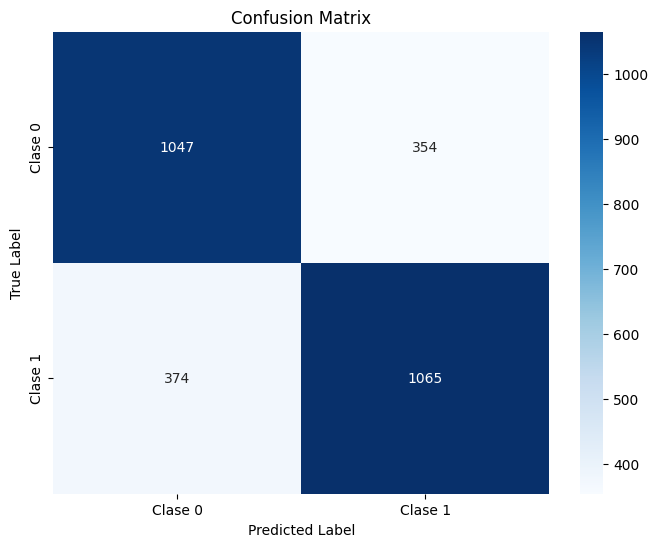

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.74      0.75      0.74      1401
           1       0.75      0.74      0.75      1439

    accuracy                           0.74      2840
   macro avg       0.74      0.74      0.74      2840
weighted avg       0.74      0.74      0.74      2840



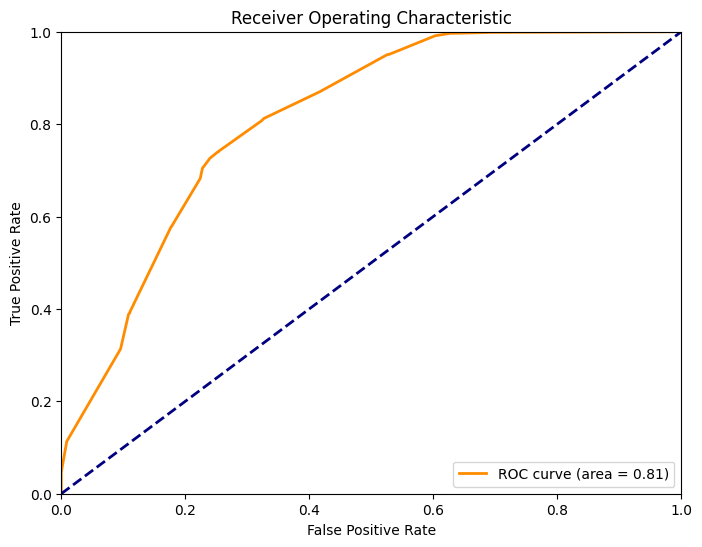

In [8]:
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


print(f"Precisión del modelo: {accuracy_final}")
plt.show()
print("Reporte de clasificación:\n", class_report)

y_prob = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()